In [3]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt

from matplotlib import pyplot as plt
from matplotlib import patches as patches
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 24, 8
%matplotlib inline

sns.set_context(context='notebook')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder

In [4]:
def prepare_data():
    non_imp = ['ps_ind_12_bin','ps_ind_13_bin','ps_ind_18_bin','ps_car_10_cat','ps_ind_11_bin','ps_ind_10_bin','ps_ind_14']
    
    train = (pd.read_csv('../data/train.csv', na_values=999)
              .fillna(value=999))
    unwanted = list((set(train.columns[train.columns.str.startswith('ps_calc_')])|set(non_imp)))
    train.drop(unwanted, axis=1, inplace=True)
            
    test  = (pd.read_csv('../data/test.csv', na_values=999)
              .fillna(value=999)
              .drop(unwanted, axis=1)) 
    
    y = train.target.values        
    train = train.drop(['id', 'target'], axis=1)
    
    test_id = test.id.values
    test = test.drop('id', axis=1)
    
    fl = train.columns.tolist()
    
    return train.values, y, test.values, test_id, fl

In [5]:
X, y, X_test, test_id, features = prepare_data()

In [69]:
import numpy as np
raw_data = np.random.randint(0, 255, (25, 10000))

In [70]:
network_dimensions = np.array([5, 5])
n_iterations = 10000
init_learning_rate = 0.01

# size of the data 
m = raw_data.shape[0]
n = raw_data.shape[1]

#weight matrix

net = np.random.random((network_dimensions[0], network_dimensions[0], m))

#initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1])/2

#radius decay parameter
time_constant = n_iterations / np.log(init_radius)

In [71]:
normalise_data = True

# if True, assume all data is on common scale
# if False, normalise to [0 1] range along each column
normalise_by_column = True

# we want to keep a copy of the raw data for later
data = raw_data

# check if data needs to be normalised
if normalise_data:
    if normalise_by_column:
        # normalise along each column
        col_maxes = raw_data.max(axis=0)
        data = raw_data / col_maxes[np.newaxis, :]
    else:
        # normalise entire dataset
        data = raw_data / data.max()

### Learning
#### for each iteration:
1. find the neuron in the SOM whose associated n-D vector is associated to the our chosen n-D vector. At each step, this is called the Best Matching Unit(BMU).
2. Move the BMU's n-D weight vector to the unput vector in n-D space
3. Identify the 2D neihbours of the BMU and also move their n-D weight vector closer to the input vector, although by a samller amount
4. update the learning rate, by reducing it at each iteration

In [61]:
def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

In [42]:
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

def calculate_influence(distance, radius):
    return np.exp(-distance**2 / (2* (radius**2)))

In [73]:
for i in range(n_iterations):
    #print('Iteration %d' % i)
    
    # select a training example at random
    t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    # now we know the BMU, update its weight vector to move closer to input
    # and move its neighbours in 2-D space closer
    # by a factor proportional to their 2-D distance from the BMU
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, 25)

In [79]:
net

array([[[ 0.58081445,  0.54539462,  0.59856786,  0.41963622,  0.54740156,
          0.42143873,  0.58349048,  0.63275224,  0.36809537,  0.33324687,
          0.63441785,  0.57384142,  0.4847475 ,  0.61638532,  0.34536598,
          0.53354172,  0.40126689,  0.5628721 ,  0.5652829 ,  0.53114855,
          0.66083906,  0.39700517,  0.63966234,  0.59484201,  0.4556122 ],
        [ 0.61982526,  0.4710445 ,  0.6327867 ,  0.4821647 ,  0.48885405,
          0.4201074 ,  0.56288059,  0.5972559 ,  0.43410961,  0.42816687,
          0.6671523 ,  0.53202365,  0.56397981,  0.58363696,  0.40375686,
          0.59595898,  0.38241253,  0.63327382,  0.52088961,  0.5059136 ,
          0.53132315,  0.40413397,  0.58331707,  0.64043547,  0.42390986],
        [ 0.65498019,  0.40896361,  0.59524438,  0.51798529,  0.47794117,
          0.49803435,  0.49376211,  0.53013038,  0.52912169,  0.58402132,
          0.65572509,  0.48194209,  0.65761317,  0.50223236,  0.47974492,
          0.59285691,  0.39750637,  

ValueError: RGBA sequence should have length 3 or 4

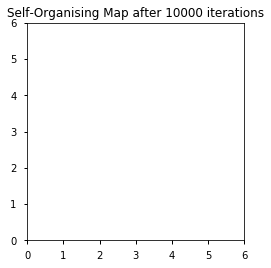

In [74]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
plt.show()

In [68]:
net

array([[[ 0.99973436,  0.28004059,  0.28313012],
        [ 0.71647879,  0.28624641,  0.62209146],
        [ 0.40200367,  0.25303241,  0.96888949],
        [ 0.59763212,  0.23471966,  0.96351302],
        [ 0.88856447,  0.23994822,  0.91461378]],

       [[ 0.98927031,  0.52203057,  0.27642215],
        [ 0.94552401,  0.61051511,  0.47841547],
        [ 0.65004297,  0.52354363,  0.84180305],
        [ 0.81457957,  0.52819805,  0.95477648],
        [ 0.91732874,  0.38721162,  0.92355721]],

       [[ 0.90177235,  0.86222781,  0.22811794],
        [ 0.92887081,  0.87012218,  0.46101708],
        [ 0.8788804 ,  0.90631532,  0.73821168],
        [ 0.84763906,  0.83966328,  0.90204132],
        [ 0.81530141,  0.67716017,  0.95900721]],

       [[ 0.62945298,  0.97255248,  0.19837252],
        [ 0.6157919 ,  0.98355975,  0.42647518],
        [ 0.63671212,  0.97323429,  0.7175133 ],
        [ 0.54680988,  0.90744025,  0.91544542],
        [ 0.4562802 ,  0.74137183,  0.98645756]],

       [[ 0.

In [64]:
in_data =  np.random.randint(0, 255, (3, 1))/255

In [65]:
in_data*255

array([[ 168.],
       [ 101.],
       [  58.]])

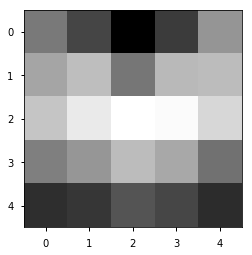

In [67]:
im = np.dot(net,in_data).reshape(5,5)
plt.imshow(im)
plt.show()

In [21]:
im

array([[ 323.6234959 ,  305.787009  ,  280.00407509,  241.96359005,
         218.67678382],
       [ 342.02401852,  316.9119777 ,  243.71147545,  220.871569  ,
         195.9801987 ],
       [ 342.539344  ,  297.52267018,  234.21662838,  190.44194787,
         156.0596191 ],
       [ 318.71103838,  302.54092268,  226.99089959,  182.97940291,
         150.2789833 ],
       [ 283.55759823,  260.03806044,  235.57138074,  213.82466634,
         169.55970146]])